In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce
from sklearn.feature_selection import chi2

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

### Загрузка данных

In [3]:
# Загрузка данных
hotels = pd.read_csv('hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


### Анализ данных

In [4]:
# Анализ данных
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
# Сколько уникальных названий отелей представлено в наборе данных?
hotels['hotel_name'].nunique()

1492

In [6]:
# Когда был оставлен самый свежий и самый первый отзыв? 
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format="%m/%d/%Y")
hotels['review_date'].sort_values()


143997   2015-08-04
86268    2015-08-04
159209   2015-08-04
217001   2015-08-04
28485    2015-08-04
            ...    
167325   2017-08-03
372341   2017-08-03
54669    2017-08-03
321881   2017-08-03
315137   2017-08-03
Name: review_date, Length: 386803, dtype: datetime64[ns]

### Отчистка данных

In [7]:
# Проверка на дубликаты
print('Количество дубликатов: {}'.format(hotels[hotels.duplicated()].shape[0]))

Количество дубликатов: 307


In [8]:
# Удаление дубликатов
hotels.drop_duplicates(inplace=True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386496 non-null  object        
 1   additional_number_of_scoring                386496 non-null  int64         
 2   review_date                                 386496 non-null  datetime64[ns]
 3   average_score                               386496 non-null  float64       
 4   hotel_name                                  386496 non-null  object        
 5   reviewer_nationality                        386496 non-null  object        
 6   negative_review                             386496 non-null  object        
 7   review_total_negative_word_counts           386496 non-null  int64         
 8   total_number_of_reviews                     386496 non-null  int64         
 9 

In [9]:
# Очистка пропусков
coll_null = hotels.isnull().mean()*100
coll_null


hotel_address                                 0.000000
additional_number_of_scoring                  0.000000
review_date                                   0.000000
average_score                                 0.000000
hotel_name                                    0.000000
reviewer_nationality                          0.000000
negative_review                               0.000000
review_total_negative_word_counts             0.000000
total_number_of_reviews                       0.000000
positive_review                               0.000000
review_total_positive_word_counts             0.000000
total_number_of_reviews_reviewer_has_given    0.000000
reviewer_score                                0.000000
tags                                          0.000000
days_since_review                             0.000000
lat                                           0.633383
lng                                           0.633383
dtype: float64

In [10]:
# Признаки lat и lng имеют пропуски, кроме того это координаты отеля, 
# которые заменяет информация об адресе. Данные признаки можно удалить
hotels.drop(['lat', 'lng'], axis=1, inplace=True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 15 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386496 non-null  object        
 1   additional_number_of_scoring                386496 non-null  int64         
 2   review_date                                 386496 non-null  datetime64[ns]
 3   average_score                               386496 non-null  float64       
 4   hotel_name                                  386496 non-null  object        
 5   reviewer_nationality                        386496 non-null  object        
 6   negative_review                             386496 non-null  object        
 7   review_total_negative_word_counts           386496 non-null  int64         
 8   total_number_of_reviews                     386496 non-null  int64         
 9 

In [11]:
# новый признак - количество ночей в отеле
hotels['tags'] = hotels['tags'].apply(lambda x: x.replace("[' ", "").replace(" ']", "").split(" ', ' "))

# Функция для получения данных о количестве ночей
def get_night(tags):
    for tag in tags:
        if 'Stayed' in tag:
            return int(tag.split()[1])
        
hotels['nights'] = hotels['tags'].apply(get_night)

In [12]:
tags = list(hotels['tags'].explode().value_counts())
len(tags)

2368

### Исследование данных

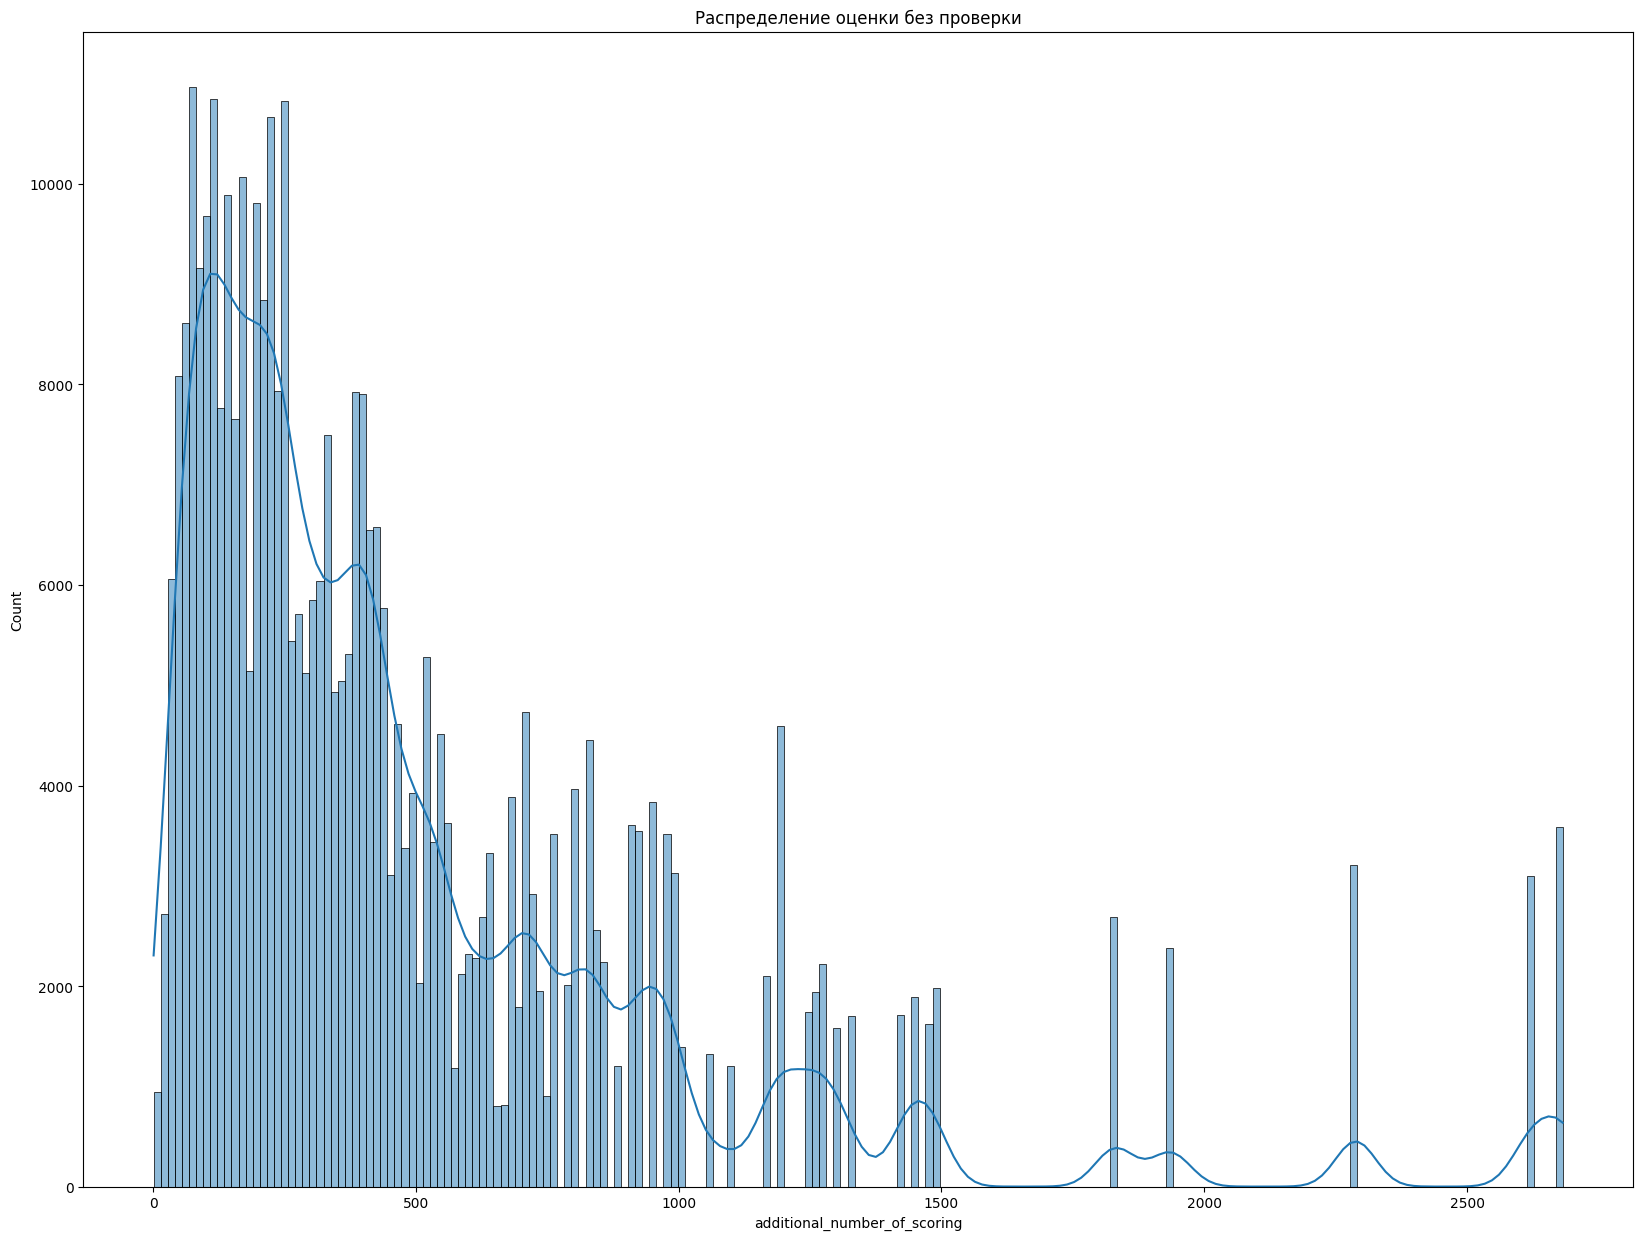

In [13]:
# Распределение числовых признаков
fig, axes = plt.subplots(figsize=(20, 15))
sns.histplot(hotels['additional_number_of_scoring'], kde=True)
plt.title('Распределение оценки без проверки')
plt.show('png')

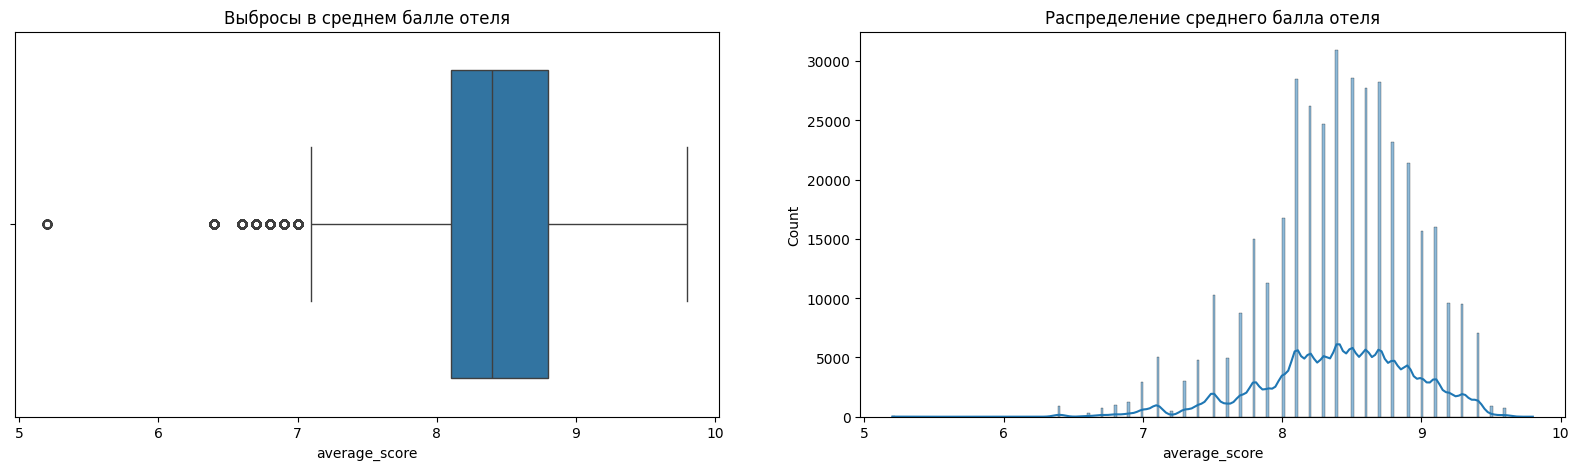

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
boxplot = sns.boxplot(data=hotels, x='average_score', ax=axes[0]);
boxplot.set_title('Выбросы в среднем балле отеля');
sns.histplot(hotels['average_score'], kde=True, ax=axes[1])
plt.title('Распределение среднего балла отеля')
plt.show('png')

Распределение среднего балла близко к нормальному, но имеются выбросы - баллы меньше 6
Можно убрать информацию об отеле с оценкой ниже 6

In [15]:
hotel_i = hotels.loc[hotels['average_score']<6].index
hotels.drop(hotel_i, axis=0)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,nights
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[Leisure trip, Couple, Studio Suite, Stayed 2 ...",531 day,2.0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[Business trip, Couple, Standard Double Room, ...",203 day,1.0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[Leisure trip, Solo traveler, Modern Double Ro...",289 day,3.0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[Leisure trip, Solo traveler, Standard Room wi...",681 day,1.0
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[Business trip, Couple, Standard Double or Twi...",516 day,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,2017-04-19,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,"[Leisure trip, Group, Club Double or Twin Room...",106 day,2.0
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2017-02-13,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.2,"[Leisure trip, Couple, Standard Double Room, S...",171 day,4.0
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2016-02-07,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.3,"[Business trip, Solo traveler, Single Room, St...",543 day,1.0
386801,31 Great Cumberland Place Westminster Borough ...,365,2017-05-21,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.2,"[Leisure trip, Solo traveler, Deluxe Double Ro...",74 days,2.0


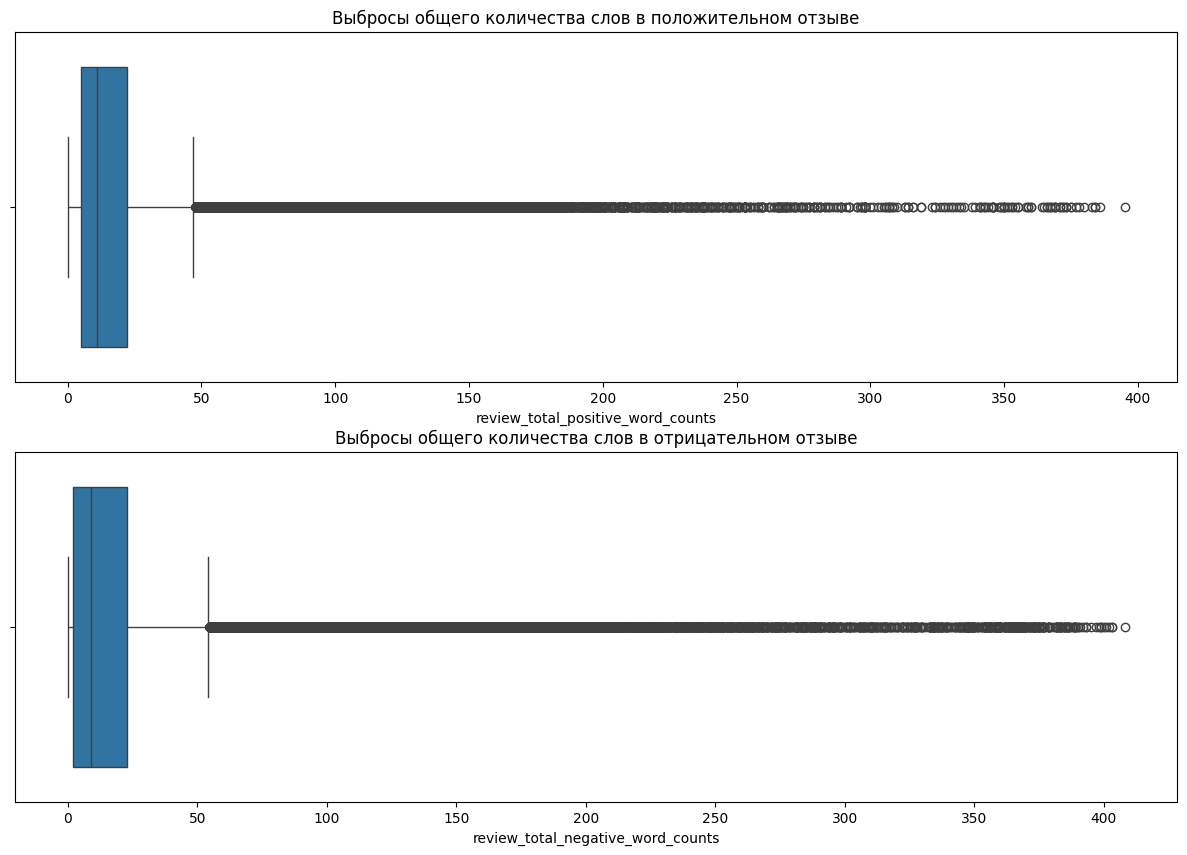

In [16]:
# посмотрим на распределение количества слов в отрицательных и положительных отзывах
fig, axes  = plt.subplots(2, figsize = (15,10))
boxplot = sns.boxplot(data=hotels, x = 'review_total_positive_word_counts', ax = axes[0])
boxplot.set_title('Выбросы общего количества слов в положительном отзыве')
boxplot = sns.boxplot(data=hotels, x = 'review_total_negative_word_counts', ax = axes[1])
boxplot.set_title('Выбросы общего количества слов в отрицательном отзыве')
plt.show('png')

Большое количество выбросов есть как в числе положительных, так и в числе отрицательных отзывах

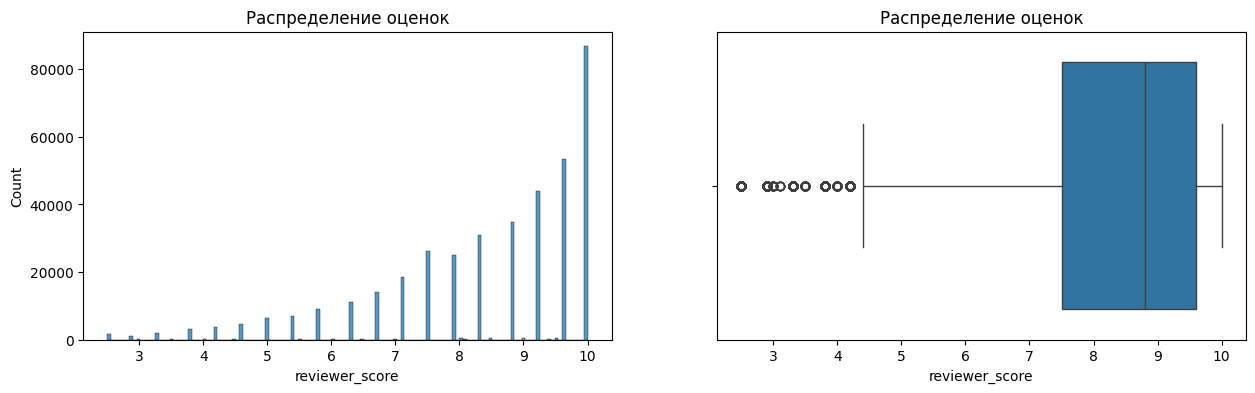

In [17]:
# Рассмотрим оценки
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=hotels, x='reviewer_score', ax=axes[0])
histplot.set_title('Распределение оценок')
boxplot = sns.boxplot(data=hotels, x='reviewer_score', ax=axes[1])
boxplot.set_title('Распределение оценок')
plt.show('png')

Рассмотрим признаки типа: object

In [18]:
hotels['hotel_address'][1]

'130 134 Southampton Row Camden London WC1B 5AF United Kingdom'

In [19]:
# рассмотрим количество стран и городов
hotels['hotel_address'].apply(lambda x: str(x.split()[-2:])).value_counts()

hotel_address
['United', 'Kingdom']           196773
['Barcelona', 'Spain']           45132
['Paris', 'France']              44528
['Amsterdam', 'Netherlands']     43004
['Vienna', 'Austria']            29177
['Milan', 'Italy']               27882
Name: count, dtype: int64

имеется 6 стран

In [20]:
# рассмотрим дату, когда резидент разместил отзыв
hotels['review_date'] = pd.to_datetime(hotels['review_date']).dt.date


In [21]:
# Выделим из даты новые признаки
hotels['review_year'] = pd.to_datetime(hotels['review_date']).dt.year
hotels['review_month'] = pd.to_datetime(hotels['review_date']).dt.month
hotels['review_quarter'] = pd.to_datetime(hotels['review_date']).dt.quarter

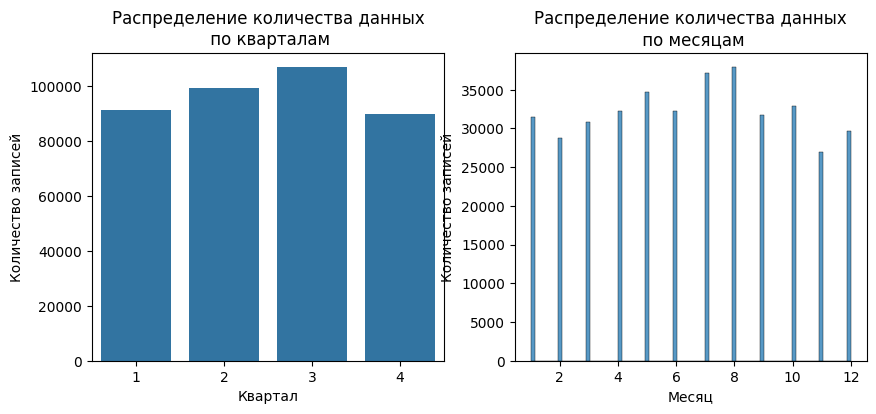

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0] = sns.countplot(hotels, x='review_quarter', ax=axes[0])
axes[0].set(xlabel='Квартал', ylabel='Количество записей')
axes[0].set_title('Распределение количества данных\n по кварталам')

axes[1] = sns.histplot(hotels['review_month'], ax=axes[1])
axes[1].set(xlabel='Месяц', ylabel='Количество записей')
axes[1].set_title('Распределение количества данных\n по месяцам')
plt.show('png')

Большой разницы между распределением количества записей по месяца и кварталам нет

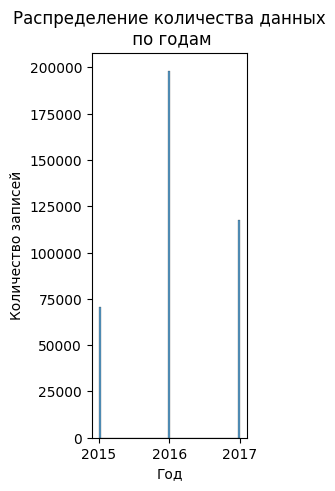

In [23]:
# Рассмотрим распределение по годам
fig, axes = plt.subplots(figsize=(2, 5))
sns.histplot(hotels['review_year'])
axes.set(xlabel='Год', ylabel='Количество записей')
axes.set_title('Распределение количества данных\n по годам')
plt.show('png')

In [24]:
# словарь с заменами для year
#mapping = {2015: 1, 2016: 2, 2017: 3}
# производим замену значений
#hotels['review_year'] = hotels['review_year'].replace(mapping)

In [24]:
# Название отеля
hotels['hotel_name'].describe()

count                                         386496
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            3587
Name: hotel_name, dtype: object

In [25]:
# Страна рецензента
hotels['reviewer_nationality'].value_counts()

reviewer_nationality
United Kingdom               183952
United States of America      26494
Australia                     16216
Ireland                       11119
United Arab Emirates           7612
                              ...  
Cook Islands                      1
Guinea                            1
Comoros                           1
Anguilla                          1
Grenada                           1
Name: count, Length: 225, dtype: int64

Возможно стоит соотнести со страной и посмотреть влияние на отзыв турист или местный

In [26]:
hotels['tags'][2]

['Leisure trip',
 'Solo traveler',
 'Modern Double Room Echo',
 'Stayed 3 nights',
 'Submitted from a mobile device']

Можно создать отдельные признаки: количество ночей, цель поездки, количество гостей, вид аппартаментов

In [27]:
hotels['negative_review'].describe()

count          386496
unique         248828
top       No Negative
freq            95833
Name: negative_review, dtype: object

Негативный отзыв, но преобладает фраза - No negativ

In [28]:
hotels['positive_review'].describe()

count          386496
unique         311737
top       No Positive
freq            26863
Name: positive_review, dtype: object

В положительных отзывах обратная ситуация - преобладает фраза: No positive
Можно выделить данную информацию в отдельные признаки

In [29]:
# days_since_review - продолжительность между датой проверки и датой очистки
hotels['days_since_review'].describe()

count     386496
unique       731
top       1 days
freq        1910
Name: days_since_review, dtype: object

### Проектирование, отбор и преобразование признаков признаков 

In [30]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 10  r

In [31]:
# Изменим признак страна, а именно объединим United Kingdom
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))
hotels['hotel_country'].value_counts()

hotel_country
United Kingdom    196773
Spain              45132
France             44528
Netherlands        43004
Austria            29177
Italy              27882
Name: count, dtype: int64

Ранее создано три новых признака на основе review_date:
'review_year'
'review_month'
'review_quarter'

In [32]:
# Признак - отзыв без негатива
hotels['no_negative'] = hotels['negative_review'].apply(lambda x: 1 if 'No Negative' in x else 0)

In [33]:
# Признак - отсутствие положительного отзыва
hotels['no_positive'] = hotels['positive_review'].apply(lambda x: 1 if 'No Positive' in x else 0)

In [34]:
# Выше был создан признак - количество ночей 
# проверим его на пустые значения
hotels[hotels['nights'].isna()].shape[0]

146

In [35]:
#заменим пустые значения медианой
hotels['nights'] = hotels['nights'].fillna(hotels['nights'].median())
hotels[hotels['nights'].isna()].shape[0]

0

In [36]:
# добавим признак - цель/вид поездки
def get_trip(tags):
    for tag in tags:
        if 'trip' in tag:
            return tag.split()[0]
        
hotels['trip'] = hotels['tags'].apply(get_trip)


In [37]:
hotels['trip'].describe()

count      375287
unique          2
top       Leisure
freq       313353
Name: trip, dtype: object

In [38]:
# проверим его на пустые значения
hotels[hotels['trip'].isna()].shape[0]

11209

In [39]:
#заменим пустые значения модой
hotels['trip'] = hotels['trip'].fillna('Leisure')
hotels[hotels['trip'].isna()].shape[0]

0

In [40]:
#Удалим признак review_date
hotels = hotels.drop(['review_date'], axis = 1)

In [41]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
object_columns

['hotel_address',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review',
 'hotel_country',
 'trip']

* 'hotel_address' - можно удалить, так как преобразовали в страну
* 'hotel_name' - можно удалить
* 'reviewer_nationality' - необходимо закодировать
* 'negative_review' - можно удалить, уже преобразован 
* 'positive_review'- можно удалить, уже преобразован 
* 'tags' - можно удалить, уже преобразован в несколько других признаков
* 'days_since_review' - преобразовать в число
* 'hotel_country' - необходимо закодировать
* 'trip'- необходимо закодировать

In [42]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

In [43]:
# Кодировка признаков
cols_cod = ['reviewer_nationality', 'trip', 'hotel_country']
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(hotels[cols_cod])


In [44]:
# Объединим данные
cols_no = [x for x in hotels.columns if hotels[x].dtype != 'object']
hotels = hotels[cols_no]
hotels = pd.concat([hotels, data_bin], axis=1)

In [ ]:
# hotels = hotels.drop(['hotel_address', 'hotel_name', 'negative_review', 'positive_review', 'tags', 'hotel_country'], axis=1)

### Отбор признаков

Text(0.5, 1.0, 'Матрица корреляции признаков')

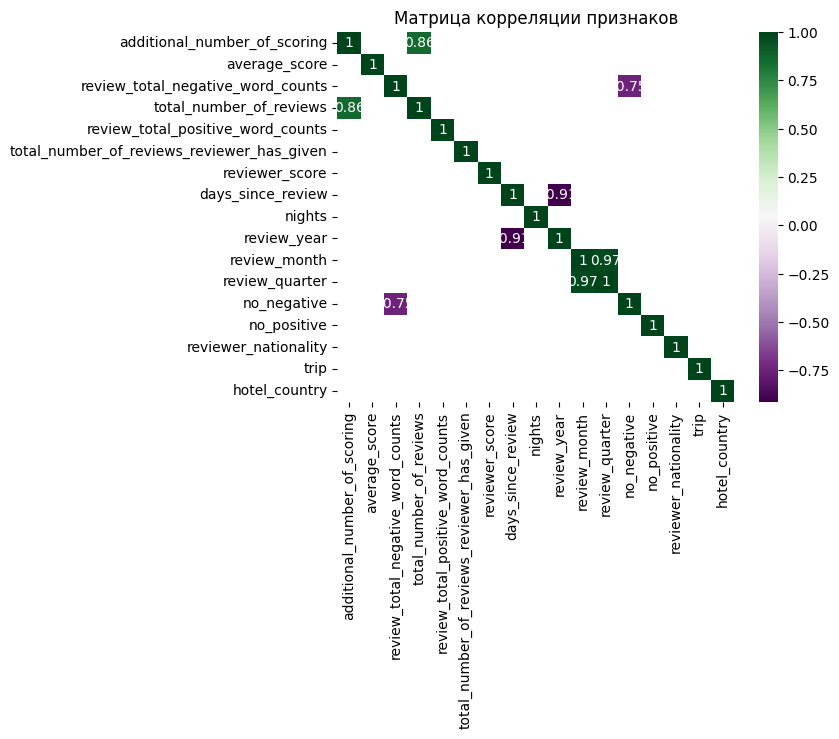

In [45]:
# Посмотрим матрицу корреляции признаков, для удобства выделим значения больше 0,7
df_corr = hotels.corr(numeric_only=True, method='spearman')
fig = sns.heatmap(df_corr[df_corr.abs() >= 0.7], annot=True, cmap='PRGn')
fig.set_title('Матрица корреляции признаков')

По графику видим, что признак 'additional_number_of_scoring' можно удалить

In [46]:
hotels.drop('additional_number_of_scoring', axis = 1, inplace=True)

In [47]:
# непрерывные признаки
num_cols = ['average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review']

# категориальные признаки
cat_cols = ['reviewer_nationality', 'trip','hotel_country', 'nights', 'no_positive', 'no_negative', 'review_quarter', 'review_month', 'review_year']

In [48]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

<Axes: >

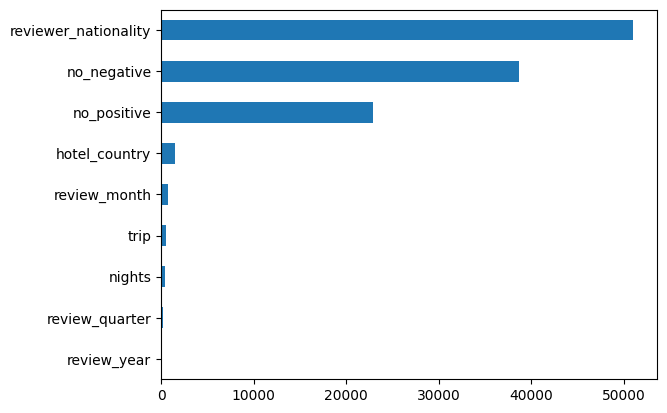

In [49]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

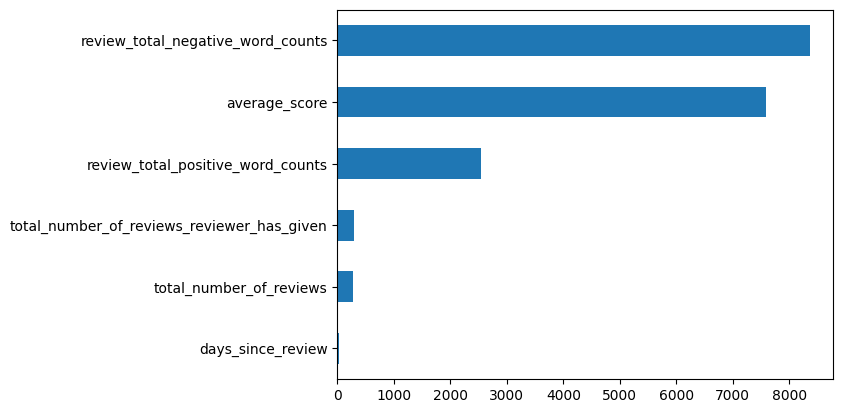

In [50]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## Создание и обучение модели

In [52]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [53]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [55]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.16090619080055757
